# Network Analysis Using Reinforcement Learning
## Spring 2022: Shaoyu Pei, Avery Peiffer

## Advisor: Dr. Mai Abdelhakim

The purpose of this notebook is to define an IoT network using the `networkx` package. The code used to create the networks is exported to `IoTgraph.py`, which we can utilize in training.

This paper is based off of Dr. Abdelhakim's work: *Identifying Malicious Nodes in Multihop IoT Networks using Diversity and Unsupervised Learning* (2018).

**Note:** If you get any errors due to packages not being installed, please add them to the cell below. We might have not encountered these errors due to already having those packages installed on our computers for other courses/projects/etc. You can install a package with: `!pip3 install <package-name>`

In [2]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

We represent a network as a graph, made up of nodes and edges. A node represents a device and an edge represents a connection between two devices. We use a partial mesh topology to define the network, which means that not all pairs of nodes are directly connected to each other (which would be a full mesh topology). The following image shows an example of a network created using the `networkx` package.

![Network Example](./network_example.png)

**Note**: To keep things clear as we write code, we have a small convention in defining the graph. The source node is always Node 0, and the destination node is always the highest-numbered node (9, in this image).

`Networkx` allows us to create a random graph according to a set of parameters. We define those parameters here:
* `network_size` - the number of devices in the network.
* `edge_prob` - how likely it is that any two devices in the network are connected. `Edge_prob = 1` means that every device is connected to every other device; this isn't useful for this study, as we want to learn about the paths from one device to another. However, we want the graph to be connected; that is, there does exist at least one path from one device to another. For this reason, we generally start with a low `edge_prob`, then make use of a method to add edges to the network until it is connected. This will result in a sparse, but connected, graph.

We also use some parameters to determine which devices in the network are malicious, as well as their potency.
* `percent_mal` - the percentage of malicious devices in the network. 
* `attack_probs` - how likely it is that the malicious devices will attack on a single transmission. We represent this as a list of two values, which form auniform distribution from which the attack probability is drawn.

In [3]:
network_size = 20      
edge_prob = 0.1 
percent_mal = 0.3
attack_probs = [0.2, 0.8] 

Here, we create the graph according to the hyperparameters defined above. We start with a random graph; then, we add edges using the `random_edge` function until the graph is connected. Again, the source node is always node 0 and the destination node is always the highest-numbered node.

In [4]:
def render(graph):
    nx.draw(graph, with_labels=True)
    plt.show()
    
def random_edge(graph):
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    if len(edges) > 0:
        chosen_edge = random.choice(edges)
        chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0] or chosen_edge[0] == x[1]])
    else:
        chosen_nonedge = random.choice(nonedges)
    
    graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])
    
    return graph

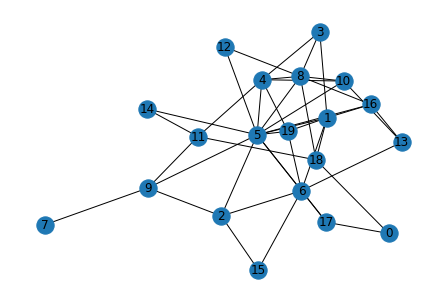

In [5]:
src = 0
dst = network_size - 1

G = nx.gnp_random_graph(network_size, edge_prob)

while not nx.is_connected(G):
    G = random_edge(G)

render(G)

At this point, we create a class to encode information for each node about whether it is malicious and, if so, what its attack probability is. We call this class `device`. We use a somewhat lazy class definition to accomplish this, as we can add attributes to the class later. 

We then randomly assign some number (according to `percent_mal`) of the devices to be malicious. We will assume that the source and destination nodes can't be malicious, since that defeats the purpose of the study.

In [6]:
class device:
    pass

In [7]:
mal_nodes = []

num_mal = int(network_size * percent_mal)

while (num_mal > 0):
    rand = np.random.randint(0, network_size)
    
    if rand != src and rand != dst and rand not in mal_nodes:
        mal_nodes.append(rand)
        num_mal -= 1

For each node in the graph, we create a corresponding `device` class for it. Each device has the following attributes:
* `node` - the label of the node in the graph.
* `mal` - a Boolean flag indicating whether the device is malicious.
* `attack_prob` - a random number drawn from the uniform distribution bounded by `attack_probs` above. This indicates how likely the device is to attack on any given transmission. If the device is not malicious, `attack_prob = 0`.

In [8]:
nodes = list(range(0, network_size))
devices = []

for node in nodes:
    d = device()
    d.node = node
    
    if node in mal_nodes:
        d.mal = True
        d.attack_prob = np.random.uniform(attack_probs[0], attack_probs[1])
    else:
        d.mal = False
        d.attack_prob = 0
        
    devices.append(d)

To verify that our network is set up correctly, we can run a brief test. First, we will print out the malicious nodes in the graph. 

In [9]:
print('Malicious Nodes:')
for d in devices:
    if d.mal:
        print(f'{d.node} - attack probability is {d.attack_prob:.2f}.')

Malicious Nodes:
2 - attack probability is 0.41.
3 - attack probability is 0.77.
5 - attack probability is 0.47.
9 - attack probability is 0.48.
15 - attack probability is 0.59.
16 - attack probability is 0.80.


The graph's `all_simple_paths` attribute gives us all of the paths from the source node to the destination node (that only visit a node once). We will go through each path and determine if a device has corrupted the path. For each malicious node along the path, we generate a random number and compare it to the node's attack probability to see if it will attack the path. 

The `is_corrupted` function represents how our network is actually able to tell whether or not a transmission was corrupted. In real life, this would be accomplished by the end device doing a hash operation on the incoming data and checking the result. In the future, this function could be changed to more closely resemble the real-life version, but still provides useful information in its current state.

**Note**: This test might take some time to run if the number of nodes is high.

In [10]:
def is_corrupted(path, verbose=True):
    for node in path: 
        attack_prob = devices[node].attack_prob
        attacked = random.uniform(0,1) < attack_prob
        
        if attacked:
            if verbose:
                print(f'Path = {path} is corrupted')
                print(f'Node {node} attacked this path')
            return True
    return False

In [11]:
paths = list(nx.all_simple_paths(G, src, dst))
paths_corruption = []

for path in paths:
    paths_corruption.append(is_corrupted(path))

Path = [0, 17, 5, 8, 18, 11, 9, 2, 15, 6, 13, 16, 1, 3, 4, 19] is corrupted
Node 9 attacked this path
Path = [0, 17, 5, 8, 18, 11, 9, 2, 15, 6, 13, 16, 1, 19] is corrupted
Node 5 attacked this path
Path = [0, 17, 5, 8, 18, 11, 9, 2, 15, 6, 13, 10, 4, 19] is corrupted
Node 15 attacked this path
Path = [0, 17, 5, 8, 18, 11, 9, 2, 15, 6, 13, 10, 4, 3, 1, 19] is corrupted
Node 9 attacked this path
Path = [0, 17, 5, 8, 18, 11, 9, 2, 15, 6, 1, 16, 13, 10, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 17, 5, 8, 18, 11, 9, 2, 15, 6, 1, 3, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 17, 5, 8, 18, 11, 9, 2, 15, 6, 1, 19] is corrupted
Node 5 attacked this path
Path = [0, 17, 5, 8, 18, 11, 9, 2, 15, 6, 19] is corrupted
Node 9 attacked this path
Path = [0, 17, 5, 8, 18, 11, 9, 2, 6, 13, 16, 1, 3, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 17, 5, 8, 18, 11, 9, 2, 6, 13, 16, 1, 19] is corrupted
Node 2 attacked this path
Path = [0, 17, 5, 8, 18, 11, 9, 2, 6, 13, 1

Node 5 attacked this path
Path = [0, 17, 5, 10, 8, 16, 1, 6, 15, 2, 9, 11, 4, 19] is corrupted
Node 16 attacked this path
Path = [0, 17, 5, 10, 8, 16, 1, 6, 2, 9, 11, 4, 19] is corrupted
Node 16 attacked this path
Path = [0, 17, 5, 10, 8, 16, 1, 3, 4, 19] is corrupted
Node 16 attacked this path
Path = [0, 17, 5, 10, 8, 16, 1, 3, 4, 11, 9, 2, 15, 6, 19] is corrupted
Node 16 attacked this path
Path = [0, 17, 5, 10, 8, 16, 1, 3, 4, 11, 9, 2, 6, 19] is corrupted
Node 16 attacked this path
Path = [0, 17, 5, 10, 8, 16, 1, 18, 11, 9, 2, 15, 6, 19] is corrupted
Node 5 attacked this path
Path = [0, 17, 5, 10, 8, 16, 1, 18, 11, 9, 2, 6, 19] is corrupted
Node 5 attacked this path
Path = [0, 17, 5, 10, 8, 16, 1, 18, 11, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 17, 5, 10, 8, 16, 1, 19] is corrupted
Node 16 attacked this path
Path = [0, 17, 5, 10, 8, 16, 13, 6, 15, 2, 9, 11, 18, 1, 3, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 17, 5, 10, 8, 16, 13, 6, 15, 2, 9, 11, 18, 

Path = [0, 17, 6, 13, 10, 4, 3, 8, 18, 11, 9, 5, 16, 1, 19] is corrupted
Node 16 attacked this path
Path = [0, 17, 6, 13, 10, 4, 3, 8, 18, 11, 9, 2, 5, 19] is corrupted
Node 9 attacked this path
Path = [0, 17, 6, 13, 10, 4, 3, 8, 18, 11, 9, 2, 5, 1, 19] is corrupted
Node 3 attacked this path
Path = [0, 17, 6, 13, 10, 4, 3, 8, 18, 11, 9, 2, 5, 16, 1, 19] is corrupted
Node 2 attacked this path
Path = [0, 17, 6, 13, 10, 4, 3, 8, 18, 11, 14, 5, 19] is corrupted
Node 3 attacked this path
Path = [0, 17, 6, 13, 10, 4, 3, 8, 18, 11, 14, 5, 16, 1, 19] is corrupted
Node 3 attacked this path
Path = [0, 17, 6, 13, 10, 4, 3, 8, 18, 1, 16, 5, 19] is corrupted
Node 3 attacked this path
Path = [0, 17, 6, 13, 10, 4, 3, 8, 18, 1, 5, 19] is corrupted
Node 3 attacked this path
Path = [0, 17, 6, 13, 10, 4, 3, 8, 16, 1, 5, 19] is corrupted
Node 3 attacked this path
Path = [0, 17, 6, 13, 10, 4, 3, 8, 16, 1, 18, 11, 9, 5, 19] is corrupted
Node 3 attacked this path
Path = [0, 17, 6, 13, 10, 4, 3, 8, 16, 1, 18,

Path = [0, 18, 8, 12, 5, 2, 6, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 8, 12, 5, 2, 9, 11, 4, 10, 13, 16, 1, 6, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 8, 12, 5, 2, 9, 11, 4, 10, 13, 16, 1, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 8, 12, 5, 2, 9, 11, 4, 10, 13, 6, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 8, 12, 5, 2, 9, 11, 4, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 8, 12, 5, 2, 9, 11, 4, 3, 1, 16, 13, 6, 19] is corrupted
Node 3 attacked this path
Path = [0, 18, 8, 12, 5, 2, 9, 11, 4, 3, 1, 6, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 8, 12, 5, 2, 9, 11, 4, 3, 1, 19] is corrupted
Node 9 attacked this path
Path = [0, 18, 8, 12, 5, 1, 16, 13, 10, 4, 19] is corrupted
Node 16 attacked this path
Path = [0, 18, 8, 12, 5, 1, 16, 13, 10, 4, 11, 9, 2, 15, 6, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 8, 12, 5, 1, 16, 13, 10, 4, 11, 9, 2, 6, 19] is corrupted
Node 2 attacked this

Path = [0, 18, 11, 9, 5, 6, 1, 3, 4, 19] is corrupted
Node 9 attacked this path
Path = [0, 18, 11, 9, 5, 6, 1, 3, 8, 4, 19] is corrupted
Node 9 attacked this path
Path = [0, 18, 11, 9, 5, 6, 1, 3, 8, 16, 13, 10, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 9, 5, 6, 1, 3, 8, 10, 4, 19] is corrupted
Node 9 attacked this path
Path = [0, 18, 11, 9, 5, 6, 1, 19] is corrupted
Node 9 attacked this path
Path = [0, 18, 11, 9, 5, 6, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 9, 5, 2, 15, 6, 13, 16, 1, 3, 4, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 11, 9, 5, 2, 15, 6, 13, 16, 1, 3, 8, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 9, 5, 2, 15, 6, 13, 16, 1, 3, 8, 10, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 9, 5, 2, 15, 6, 13, 16, 1, 19] is corrupted
Node 9 attacked this path
Path = [0, 18, 11, 9, 5, 2, 15, 6, 13, 16, 8, 4, 19] is corrupted
Node 9 attacked this path
Path = [0, 18, 11, 9, 5, 2, 15, 6,

Node 2 attacked this path
Path = [0, 18, 11, 4, 8, 5, 1, 16, 13, 6, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 4, 8, 5, 1, 6, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 4, 8, 5, 16, 1, 6, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 4, 8, 5, 16, 1, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 4, 8, 5, 16, 13, 6, 1, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 4, 8, 5, 16, 13, 6, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 4, 8, 5, 10, 13, 16, 1, 19] is corrupted
Node 16 attacked this path
Path = [0, 18, 11, 4, 8, 12, 5, 17, 6, 13, 16, 1, 19] is corrupted
Node 16 attacked this path
Path = [0, 18, 11, 4, 8, 12, 5, 17, 6, 1, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 4, 8, 12, 5, 17, 6, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 4, 8, 12, 5, 9, 2, 15, 6, 13, 16, 1, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 11, 4, 8, 12, 5, 9, 2, 1

Path = [0, 18, 1, 6, 2, 5, 12, 8, 3, 4, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 1, 6, 2, 5, 12, 8, 10, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 1, 6, 2, 5, 4, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 1, 6, 2, 5, 16, 13, 10, 4, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 1, 6, 2, 5, 16, 13, 10, 8, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 1, 6, 2, 5, 16, 13, 10, 8, 3, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 1, 6, 2, 5, 16, 8, 4, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 1, 6, 2, 5, 16, 8, 3, 4, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 1, 6, 2, 5, 16, 8, 10, 4, 19] is corrupted
Node 16 attacked this path
Path = [0, 18, 1, 6, 2, 5, 10, 4, 19] is corrupted
Node 5 attacked this path
Path = [0, 18, 1, 6, 2, 5, 10, 13, 16, 8, 4, 19] is corrupted
Node 2 attacked this path
Path = [0, 18, 1, 6, 2, 5, 10, 13, 16, 8, 3, 4, 19] is corrupted
Node 2 attacked th

We also have support for loading a custom graph from the `./env` folder. The formatting of the environment files is relatively simple and is outlined in `./env/env_format.txt`. If you choose to load in predefined graphs, please make sure that the files are read in correctly and there are no typos anywhere. Try loading it here first to make sure that everything makes sense.

In [12]:
def read_network(fname):
    with open(fname) as f:
        lines = [line.rstrip() for line in f]
        print(f'Lines: {lines}')
        
        network_size = int(lines[0])
        print(f'Network size: {network_size}')
        
        edges = [eval(x) for x in lines[1:-1]]
        print(f'Edges: {edges}')
        
        attack_probs = [float(x) for x in lines[-1].split(',')]
        print(f'Attack probabilities: {attack_probs}')

In [13]:
read_network('./sample_envs/env1.txt')

Lines: ['10', '0,2', '2,1', '3,0', '3,1', '5,0', '5,1', '1,9', '0,4', '0,6', '0,7', '0,8', '0,0,0,.64,0,.85,0,0,0,0']
Network size: 10
Edges: [(0, 2), (2, 1), (3, 0), (3, 1), (5, 0), (5, 1), (1, 9), (0, 4), (0, 6), (0, 7), (0, 8)]
Attack probabilities: [0.0, 0.0, 0.0, 0.64, 0.0, 0.85, 0.0, 0.0, 0.0, 0.0]
